## Felix and Galtiers Algorithm Implementation
To install osmnx use:
- conda config --prepend channels conda-forge
- conda create -n ox --strict-channel-priority osmnx
- conda activate ox
- python -m ipykernel install --user --name ox --display-name "Python (ox)"
- jupyter notebook
Interest Links:
- https://towardsdatascience.com/finding-time-dependent-travel-times-between-every-pair-of-locations-in-manhattan-c3c48b0db7ba
- https://github.com/nick-caros/nyc-travel-times/blob/main/Manhattan-Travel-Times.ipynb

In [1]:
#Import needed packages
import osmnx as ox
import pandas as pd
import networkx as nx
import numpy as np

C:\Anaconda3\envs\ox\lib\site-packages\osmnx\geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


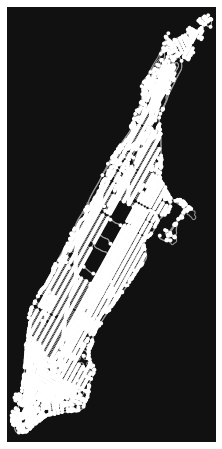

In [2]:
# Import Manhattan network and change node labels to integers
G = ox.graph_from_place('Manhattan, New York, USA', network_type='drive')

# If a node cannot access at least 10% of other nodes, delete it (isolated)
remove_list = []
num_nodes = len(G.nodes)
for node in G.nodes:  
    reach = len(nx.descendants(G, node))
    if reach < num_nodes / 10:
        remove_list.append(node)

for node in remove_list:
    G.remove_node(node)

G = nx.convert_node_labels_to_integers(G, label_attribute='old_node_ID')
ox.plot_graph(G);

In [3]:
G = ox.add_edge_speeds(G)
G = ox.speed.add_edge_travel_times(G, precision=1)

In [4]:
# Use Uber Movement data to get average speed for all ways during each hour of the average weekday
speed_df = pd.read_csv('Data/nyc_avg_speeds_2019-06.csv') # downloaded from Uber Movement
speed_df = speed_df[['osm_way_id', 'hour', 'speed']]
speed_df.head()

,osm_way_id,hour,speed
0,5029221,0,23.508350
1,5029221,1,24.487867
2,5029221,2,24.330429
3,5029221,3,28.003333
4,5029221,4,24.547684


In [5]:
# Convert to dictionary with way IDs and hour of the day as keys
speed_dict = dict([((t.osm_way_id, t.hour), t.speed) for t in speed_df.itertuples()])
speed_dict[(5029221, 0)]

23.50835

In [6]:
#Append the distance / speed of each edge in the graph to the graph properties as travel time
for edge in G.edges:
    edge_obj = G[edge[0]][edge[1]][edge[2]]
    wayid = edge_obj['osmid']
    try:
        speed = speed_dict[wayid] * 1.60934 # Convert from mph to kph
        distance = edge_obj['length'] / 1000 # Convert from m to km
        travel_time = distance / speed * 60 # Convert from hours to minutes
    except:
        travel_time = edge_obj['travel_time'] / 60 # Convert from seconds to minutes
    G[edge[0]][edge[1]][edge[2]]['um_travel_time'] = travel_time

In [12]:
print(G.nodes[0])
print(G.edges)

{'y': 40.7980478, 'x': -73.9600437, 'highway': 'traffic_signals', 'street_count': 3, 'old_node_ID': 42421728}
[(0, 1012, 0), (0, 1316, 0), (0, 1, 0), (1, 1730, 0), (1, 1013, 0), (1, 0, 0), (1, 2, 0), (2, 1731, 0), (2, 1, 0), (2, 3, 0), (3, 1015, 0), (3, 3733, 0), (3, 2, 0), (4, 3733, 0), (4, 5, 0), (4, 435, 0), (5, 6, 0), (5, 4, 0), (5, 826, 0), (6, 1016, 0), (6, 5, 0), (7, 2301, 0), (8, 7, 0), (8, 2150, 0), (9, 3719, 0), (9, 412, 0), (10, 9, 0), (10, 804, 0), (10, 803, 0), (11, 10, 0), (11, 61, 0), (11, 2099, 0), (12, 2318, 0), (12, 239, 0), (12, 502, 0), (12, 4512, 0), (13, 14, 0), (13, 2317, 0), (14, 15, 0), (15, 4245, 0), (15, 2765, 0), (16, 120, 0), (16, 1307, 0), (17, 1658, 0), (17, 16, 0), (18, 2151, 0), (18, 17, 0), (19, 3735, 0), (19, 415, 0), (20, 19, 0), (20, 806, 0), (20, 807, 0), (21, 20, 0), (21, 1660, 0), (21, 2098, 0), (22, 786, 0), (22, 785, 0), (23, 3441, 0), (23, 2172, 0), (23, 1839, 0), (24, 25, 0), (24, 3441, 0), (24, 3782, 0), (25, 24, 0), (25, 2286, 0), (25, 3771

In [7]:
#Get shortest paths between all nodes and store the travel time as an array.
num_nodes = len(G.nodes)
shortest_time = np.zeros((num_nodes, num_nodes))

path_generator = nx.shortest_path_length(G, weight='um_travel_time')#Here I can put a paramter source= or target=
for origin_data in path_generator:
    origin = origin_data[0]
    dist_dict = origin_data[1]
    for destination in dist_dict:
        shortest_time[origin, destination] = dist_dict[destination]